# Задание

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года. В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

In [42]:
#импорт библиотек
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from scipy import stats as st

import numpy as np

Описание данных
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы долларов)
- EU_sales — продажи в Европе (миллионы долларов)
- JP_sales — продажи в Японии (миллионы долларов)
- Other_sales — продажи в других странах (миллионы долларов)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [43]:
#чтение файла
games = pd.read_csv("/datasets/games.csv")
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


## Предобработка данных

In [44]:
#перевод названий колонок в нижний регистр
games.columns = games.columns.str.lower()

In [45]:
#выводим первые строки таблицы
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [46]:
#проверили на дубликаты
games.duplicated().sum()

0

In [47]:
#перевод значений в столбце в целочисленное
games['year_of_release'] = games['year_of_release'].fillna(value='0').astype('int')

In [48]:
#заполянем пропуски
#games['name'] = games['name'].fillna(value='noname')

In [49]:
#строки с пустым значением
games.loc[games['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Пустые значения года выхода игры переводим в 0, так как не знаем точной даты.

In [50]:
#уникальные значения
games['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
0.3       2
2.3       2
1.9       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

tbd (to be determined). Перевод, соответственно, такой: «будет утверждено» и «будет определено»

In [51]:
#сумма продаж
games['sum_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

### Исследовательский анализ

Text(0.5, 1.0, 'Количество игр по годам')

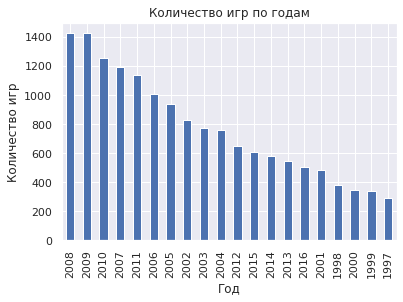

In [52]:
#посмотрели сколько игр выпускалось ежегодно
games['year_of_release'].value_counts().sort_values(ascending=False).head(20).plot(kind='bar')
plt.ylabel('Количество игр')
plt.xlabel('Год')
plt.title('Количество игр по годам')

Самые успешные годы по количеству выпущенных игр - это 2008, 2009. После этого количества идет на спад, новые игры не выходят. 

In [53]:
#5 самых успешных платформ по продажам за все время
top_platforms = (games
                .pivot_table(index='platform',values='sum_sales', aggfunc='sum') #сводная таблица суммарных продаж по платформам
                .reset_index()                                                   #сбросили индексы
                .sort_values('sum_sales',ascending=False)                        #сортировка по убыванию
                .head())                                                         #первые 5 строк
top_platforms_list = top_platforms['platform'].tolist()                          #список платформ
top_platforms

,platform,sum_sales
16,PS2,1255.77
28,X360,971.42
17,PS3,939.65
26,Wii,907.51
4,DS,806.12


In [54]:
print ('Самые популярные платформы за все время', top_platforms_list)

Самые популярные платформы за все время ['PS2', 'X360', 'PS3', 'Wii', 'DS']


Text(0.5, 1.0, 'Распределение топ платформ по годам')

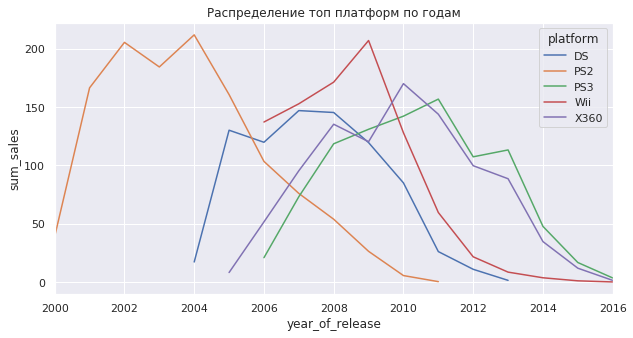

In [55]:
sns.set()
(games
 .query('year_of_release > 1995 and platform == @top_platforms_list')                       #срез по году и списку платформ
 .pivot_table(index='year_of_release',columns='platform',values='sum_sales', aggfunc='sum') #сводная таблица распределения
                                                                                            #суммарных продаж по годам
 .plot(figsize=(10,5))                                                                      #график plot
)
plt.ylabel('sum_sales')                                                                     #название вертикальной оси
plt.title('Распределение топ платформ по годам')                                            #название графика

В среднем проходит 10 лет от выпуска игры до ее ухода с рынка. 

Изучим платформы за последние 10 лет (если текущий период 2017 год)

Text(0.5, 1.0, 'Распределение платформ за последние 10 лет')

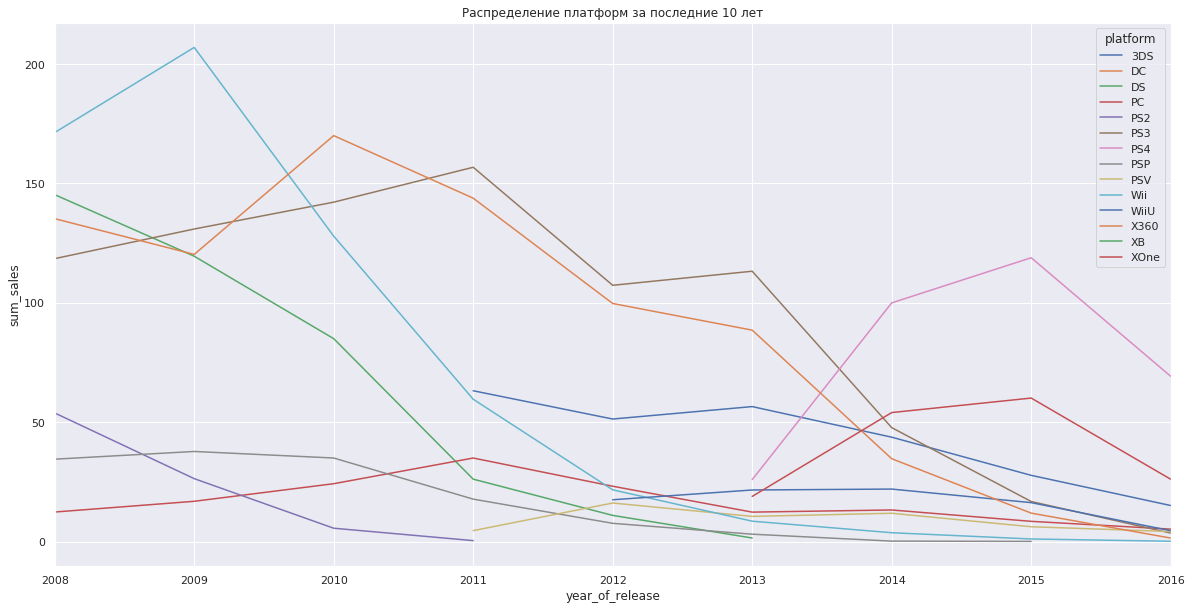

In [56]:
#распределение платформ по годам за последние 10 лет
(games
 .query('year_of_release > 2007')                                                           #срез по году
 .pivot_table(index='year_of_release',columns='platform',values='sum_sales', aggfunc='sum') #сводная таблица
 .plot(figsize=(20,10))                                                                     #график
)
plt.ylabel('sum_sales')                                                                     #название оси
plt.title('Распределение платформ за последние 10 лет')                                     #название графика

    Новые платформы за последние пару лет не появлялись. Платформы, которые появились относительно недавно - это PS4 и XOne в 2013 году. Учитывая, что в среднем платформы живут по 10 лет, у этих двух в запасе еще есть около 6 лет.
    Теперь выберем актуальный период для прогнозирования продаж на 2017 год. Проанализировав весь период, мы видим что есть закономерность: новая платформа появляется, достигает своего пика продаж и затем идет на спад. В среднем необходимо около 2-х лет, чтобы выйти на пик. Платформы PS4 и XOne достигли своего пика, поэтому ждем снижение. Две платформы 3DS и PSV появились в 2011 году, но на текущий момент не достигли уровней PS4 и XOne и за 2 года не вышли на максимумы, поэтому ждать роста не будем. В итоге для анализа возьмем данные за последний год 2016.

In [57]:
#популярные платформы после 2014 года
top_platforms_2016 = (games
 .query('year_of_release > 2015')                                  #срез по году
 .pivot_table(index='platform',values='sum_sales', aggfunc='sum')  #сводная таблица
 .reset_index()                                                    #сбросили индексы
 .sort_values('sum_sales',ascending=False)                         #сортировка таблицы
)
top_platforms_2016                                                 #вывод результата

,platform,sum_sales
3,PS4,69.25
8,XOne,26.15
0,3DS,15.14
1,PC,5.25
6,WiiU,4.60
4,PSV,4.25
2,PS3,3.60
7,X360,1.52
5,Wii,0.18


In [58]:
# 3 потенциально прибыльные плаформы за 2016 год 
top_3_platforms_2016_list = top_platforms_2016['platform'].tolist()[:3]
top_3_platforms_2016_list

['PS4', 'XOne', '3DS']

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Продажи на топ 3 платформах за 2016 год')

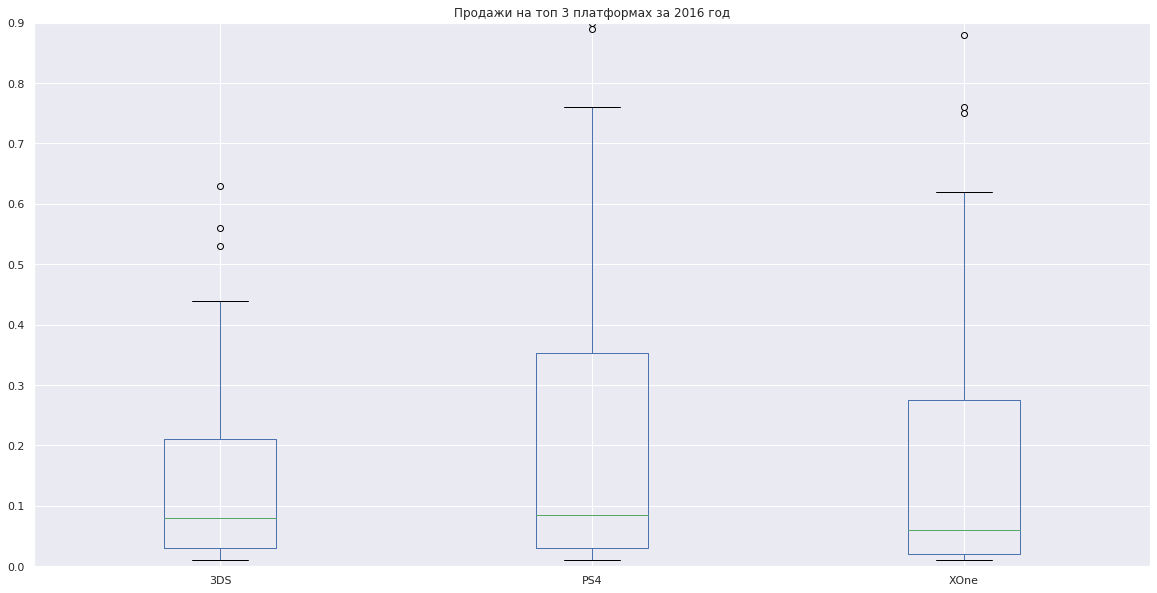

In [59]:
#график "Ящик с усами" по общим продажам для топ платформ
(games
 .query('year_of_release > 2015 & platform == @top_3_platforms_2016_list')
 .pivot_table(index='name',columns='platform',values='sum_sales', aggfunc='sum')
 .boxplot(figsize=(20,10))
)
plt.ylim(0, 0.9)
plt.title('Продажи на топ 3 платформах за 2016 год')

 Самые большие продажи игр и самая высокая средняя стоимость игры на платформе PS4, потому что большее количество игр разработаны на этой платформе. Второй результат по количеству продаж на XOne. Но сравнив медианное значение по продажам, делаем вывод, что игры на платформе 3DS выгоднее, чем на XOne.  

In [60]:
#перевод в целочисленное значение
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')

In [61]:
top_3_platforms_2016_list

['PS4', 'XOne', '3DS']

AxesSubplot(0.125,0.125;0.62x0.755)


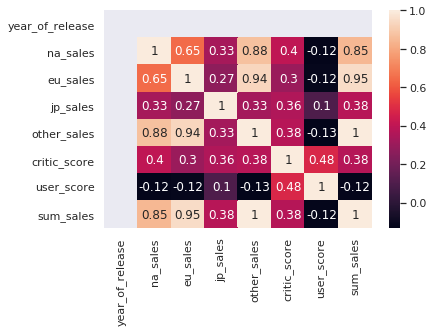

AxesSubplot(0.125,0.125;0.62x0.755)


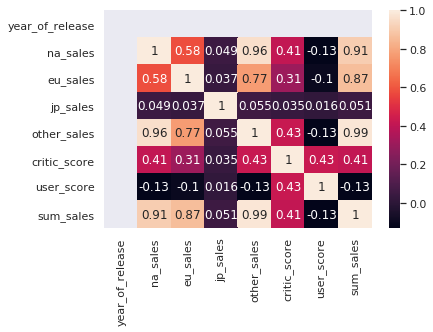

AxesSubplot(0.125,0.125;0.62x0.755)


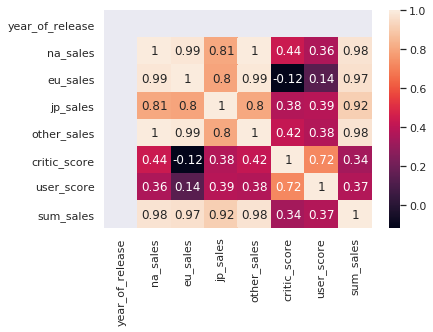

In [62]:
#цикл для построения графика корреляции между продажами и отзывами критиков
for key in top_3_platforms_2016_list:
    print(sns.heatmap(games.loc[(games['year_of_release'] >2015) & (games['platform'] == key)].corr(),annot=True))
    plt.show()

Отзывы критиков оказывают небольшое влияние на продажи на платформе PS4 и XOne, а отзывы пользователей не влияют. Отзывы пользователей оказывают небольшое влияние на продажи на платформе 3DS. Наименьшее количество продаж игр на платформе XOne было в Японии. 

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(0, 5)

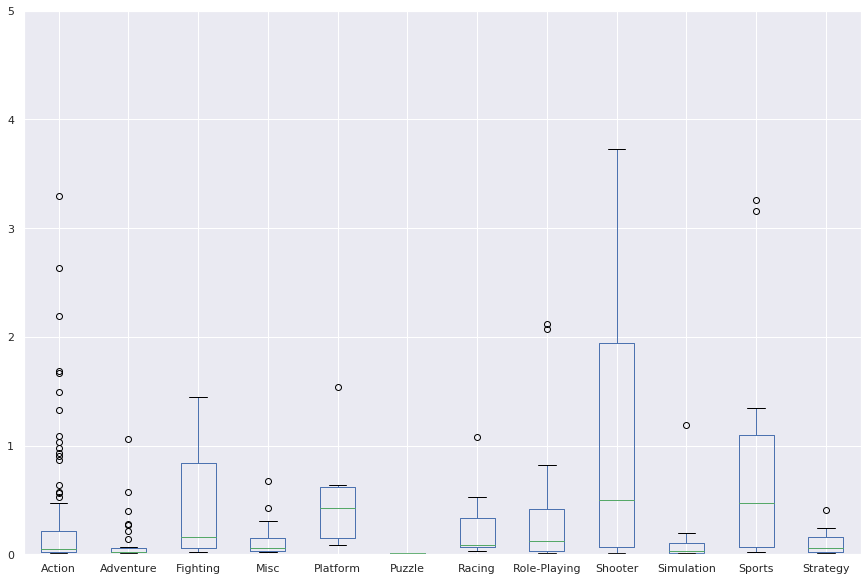

In [63]:
#график "Ящик с усами" по общим продажам для жанров
(games
 .query('year_of_release > 2015')
 .pivot_table(index='name',columns='genre',values='sum_sales', aggfunc='sum')
 .boxplot(figsize=(15,10))
)
plt.ylim(0, 5)

Самые популярный жанр игр Shooter (Стрелялки), затем Sports (Спорт), Fighting (Борьба). Наименее популярные жанры: Приключения, Пазлы. 

### Портрет пользователя каждого региона

In [64]:
#цикл топ платформ и жанров для каждого региона
for column in ['na_sales','eu_sales','jp_sales','other_sales','sum_sales']:
        print(games
          .query('year_of_release > 2015')
          .pivot_table(index='platform',values=column, aggfunc='sum')
          
          .sort_values(column, ascending=False)[:5])
        print()
        print(games
          .query('year_of_release > 2015')
          .pivot_table(index='genre',values=column, aggfunc='sum')
          
          .sort_values(column, ascending=False)[:5])
        print()
        print()
    

          na_sales
platform          
PS4          21.49
XOne         14.27
3DS           4.14
WiiU          2.10
PC            1.36

              na_sales
genre                 
Shooter          16.24
Action            9.29
Sports            7.54
Role-Playing      5.89
Fighting          1.84


          eu_sales
platform          
PS4          31.78
XOne          9.63
PC            3.53
3DS           2.33
WiiU          1.48

              eu_sales
genre                 
Shooter          15.90
Sports           12.01
Action           10.68
Role-Playing      4.28
Racing            1.77


          jp_sales
platform          
3DS           8.03
PS4           5.74
PSV           3.56
PS3           1.30
WiiU          0.67

              jp_sales
genre                 
Action            7.07
Role-Playing      6.61
Adventure         1.18
Shooter           1.06
Misc              1.04


          other_sales
platform             
PS4             10.24
XOne             2.24
3DS              0.64

Самые популярные платформы в мире PS4, XOne, 3DS.  Самые популярные жанры игр в мире Shooter (Стрелялки), затем Sports (Спорт), Fighting (Борьба).
  - Самые популярные платформы: 
- в Америке PS4, XOne, 3DS
- в Европе  PS4, XOne, PC
- в Японии 3DS, PS4, PSV
  - Самые популярные жанры:
- в Америке Shooter, Action, Sports
- в Европе  Shooter,Sports,Action
- в Японии Action, Role-Playing, Adventure

Построим ящик с усами по жанрам для каждого региона.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(0, 2)

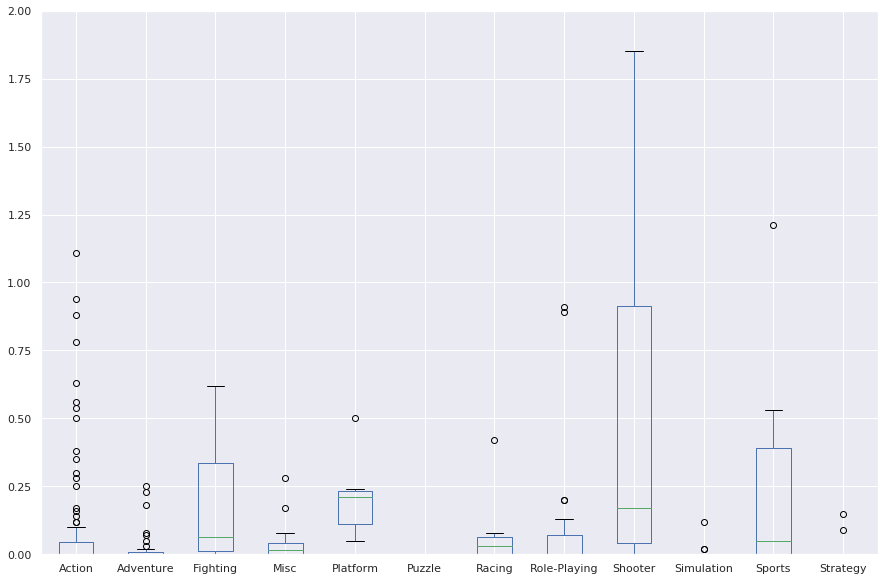

In [65]:
#график "Ящик с усами" по общим продажам для жанров для Америки
(games
 .query('year_of_release > 2015')
 .pivot_table(index='name',columns='genre',values='na_sales', aggfunc='sum')
 .boxplot(figsize=(15,10))
)
plt.ylim(0, 2)

Самые популярный жанр игр Shooter (Стрелялки), затем Sports (Спорт), Fighting (Борьба). 

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(0, 2)

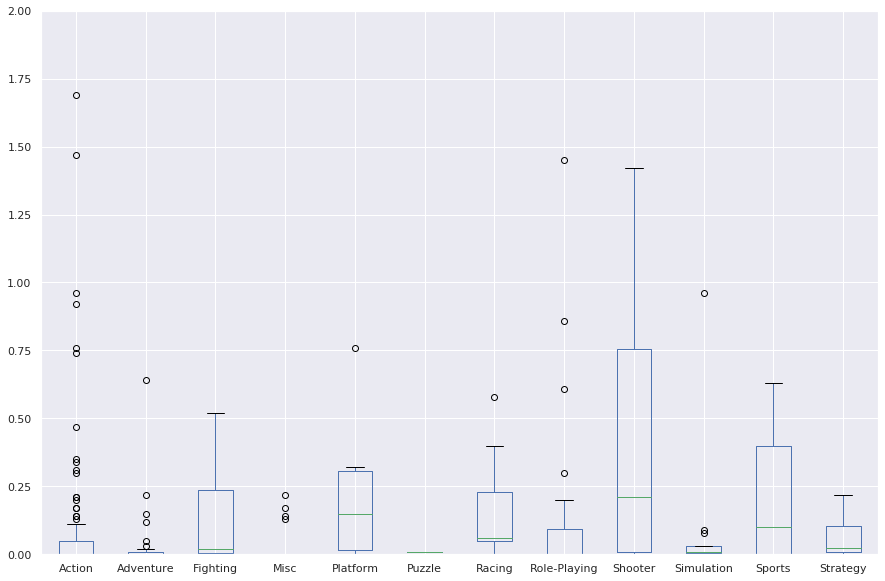

In [66]:
#график "Ящик с усами" по общим продажам для жанров для Европы
(games
 .query('year_of_release > 2015')
 .pivot_table(index='name',columns='genre',values='eu_sales', aggfunc='sum')
 .boxplot(figsize=(15,10))
)
plt.ylim(0, 2)

Самые популярные жанры в Европе: Shooter (Стрелялки), затем Sports (Спорт), Fighting (Борьба).
Action по сумме продаж входит в топ жанров, но "ящик с усами" показывает выбросы.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(0, 0.5)

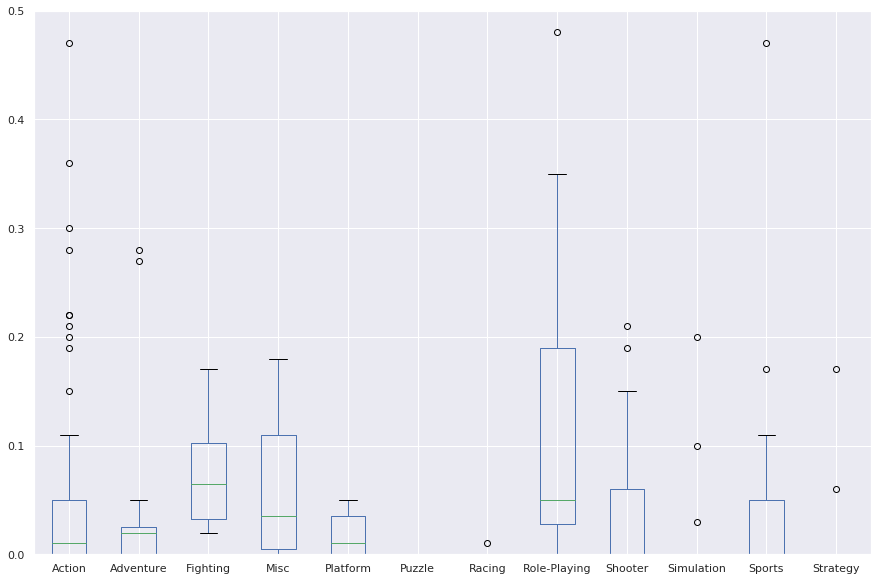

In [67]:
#график "Ящик с усами" по общим продажам для жанров для Японии
(games
 .query('year_of_release > 2015')
 .pivot_table(index='name',columns='genre',values='jp_sales', aggfunc='sum')
 .boxplot(figsize=(15,10))
)
plt.ylim(0, 0.5)

Самые популярные жанры в Японии: Role-Playing, Misc, Fighting

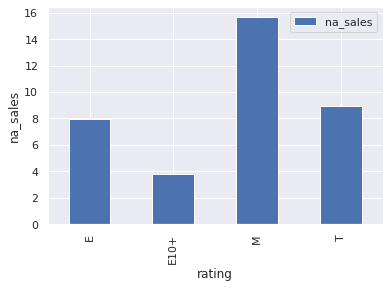

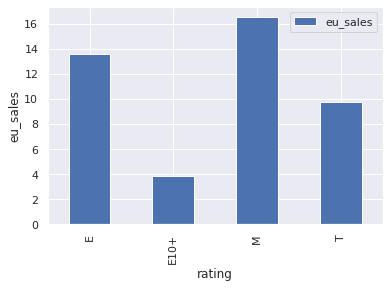

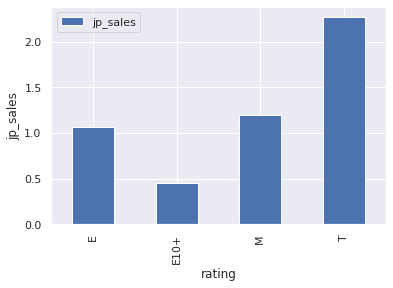

In [68]:
#цикл гистограмм рейтинга ESRB для каждого региона
for column in ['na_sales','eu_sales','jp_sales']:
    games.query('year_of_release > 2015').pivot_table(index='rating', values=column, aggfunc='sum').plot(kind='bar')
    plt.ylabel(column)

В Европе и Америке наибольшие продажи игр с рейтингом M (для взрослых), в Японии - это T (для подростков)

# Гипотезы

In [69]:
#удаляем пустые строки с рейтингом пользователей
games_user_score = games.dropna(subset=['user_score'])

In [70]:
#таблица пользовательских рейтингов для платформы XOne 
games_Xbox_One = games_user_score.query('platform == "XOne"')['user_score']

In [71]:
#таблица пользовательских рейтингов для платформы PS4 
games_PS4 = games_user_score.query('platform == "PS4"')['user_score']

In [72]:
#таблица пользовательских рейтингов для платформы PC
games_PC = games_user_score.query('platform == "PC"')['user_score']

In [73]:
#средний рейтинг пользователей для XOne
games_Xbox_One.mean()

6.521428571428572

In [74]:
#средний рейтинг пользователей для PC
games_PC.mean()

7.062467532467533

Нулевая гипотеза: Средние пользовательские рейтинги платформ XOne И PC равны, альтернативная гипотеза - рейтинги не равны. 

In [75]:
#проверка гипотезы
alpha = .05

results = st.ttest_ind(
    games_Xbox_One,
    games_PC)

print('p-значение', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение 1.3896435533548819e-05
Отвергаем нулевую гипотезу


In [76]:
#средний рейтинг пользователей для PS4
games_PS4.mean()

6.748249027237354

Нулевая гипотеза: Средние пользовательские рейтинги платформ XOne И PS4 равны, альтернативная гипотеза - рейтинги не равны. 

In [77]:
#проверка гипотезы
alpha = .05

results = st.ttest_ind(
    games_Xbox_One,
    games_PS4)

print('p-значение', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение 0.10169342039498884
Не получилось отвергнуть нулевую гипотезу


In [78]:
#таблица пользовательских рейтингов для жанра Action
games_action = games_user_score.query('genre == "Action"')['user_score']

In [79]:
#средний рейтинг пользователей для жанра Action
games_action.mean()

7.054043715846995

In [80]:
#таблица пользовательских рейтингов для жанра Sports
games_sport = games_user_score.query('genre == "Sports"')['user_score']

In [81]:
#средний рейтинг пользователей для жанра Sports
games_sport.mean()

6.961196736174069

Нулевая гипотеза: Средние пользовательские рейтинги жанров Action И Sports равны, альтернативная гипотеза - рейтинги не равны. 

In [82]:
#проверка гипотезы
alpha = .05

results = st.ttest_ind(
    games_action, 
    games_sport)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу, Средние пользовательские рейтини жанров Action и Sport равны")

p-значение: 0.10406951359049141
Не получилось отвергнуть нулевую гипотезу, Средние пользовательские рейтини жанров Action и Sport равны


# ВЫВОДЫ

Новые платформы за последние пару лет не появлялись. Платформы, которые появились относительно недавно - это PS4 и XOne в 2013 году. Учитывая, что в среднем платформы живут по 10 лет, у этих двух в запасе еще есть около 6 лет.
    Теперь выберем актуальный период для прогнозирования продаж на 2017 год. Проанализировав весь период, мы видим что есть закономерность: новая платформа появляется, достигает своего пика продаж и затем идет на спад. В среднем необходимо около 2-х лет, чтобы выйти на пик. Платформы PS4 и XOne достигли своего пика, поэтому ждем снижение. Две платформы 3DS и PSV появились в 2011 году, но на текущий момент не достигли уровней PS4 и XOne и за 2 года не вышли на максимумы, поэтому ждать роста не будем. В итоге для анализа возьмем данные за последний год 2016. Самые большие продажи игр и самая высокая средняя стоимость игры на платформе PS4, потому что большее количество игр разработаны на этой платформе. Второй результат по количеству продаж на XOne. Но сравнив медианное значение по продажам, делаем вывод, что игры на платформе 3DS выгоднее, чем на XOne.  Отзывы критиков оказывают небольшое влияние на продажи на платформе PS4 и XOne, а отзывы пользователей не влияют совсем. Отзывы пользователей оказывают небольшое влияние на продажи на платформе 3DS. Самые популярный жанр игр Shooter (Стрелялки), затем Sports (Спорт), Fighting (Борьба). Наименее популярные жанры: Приключения, Пазлы. Поведение клиентов в Америке и Европе отличаются от клиентов в Японии.

  - Самые популярные платформы: 
- в Америке PS4, XOne, 3DS
- в Европе  PS4, XOne, PC
- в Японии 3DS, PS4, PSV

Самые популярные жанры в Америке и Европе: Shooter (Стрелялки), затем Sports (Спорт), Fighting (Борьба).Самые популярные жанры в Японии: Role-Playing, Misc, Fighting. В Европе и Америке наибольшие продажи игр с рейтингом M (для взрослых), в Японии - это T (для подростков)